# Testing hypotheses on synthetic dummy data

## Setup & loading data

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ttest_1samp, ttest_rel
from sklearn.linear_model import LinearRegression

In [2]:
responses_t1 = pd.read_csv("dataset_T1.csv", index_col=0)
responses_t2 = pd.read_csv("dataset_T2.csv", index_col=0)

# Explicltly calculate differences between the *_t2 columns in the responses_t2 dataframe, using the names as in the responses_t1 dataframe
differences = responses_t1[[column[:-3] for column in responses_t2.columns]] - responses_t2.rename(columns=lambda x: x[:-3])

### Create the aggregated values

biospheric ((pv19 + pv22)/2), altruistic ((pv3 + pv12 + pv18)/3), hedonic ((pv10 + pv21)/2) and egoistic ((pv2 + pv4 + pv13)/3)

In [3]:
aggregation_names = ['altruistic', 'biospheric', 'egoistic', 'hedonic']
responses_t1['hedonic']    = responses_t1[[f'pv{i}' for i in [10, 21]]].mean(axis=1)
responses_t1['biospheric'] = responses_t1[[f'pv{i}' for i in [19, 22]]].mean(axis=1)
responses_t1['egoistic']   = responses_t1[[f'pv{i}' for i in [ 2,  4, 13]]].mean(axis=1)
responses_t1['altruistic'] = responses_t1[[f'pv{i}' for i in [ 3, 12, 18]]].mean(axis=1)

responses_t1[aggregation_names].head()

,altruistic,biospheric,egoistic,hedonic
participant_0,5.666667,2.0,2.666667,5.0
participant_1,4.000000,4.0,3.000000,3.5
participant_2,1.666667,4.5,3.666667,5.0
participant_3,5.000000,5.0,3.000000,4.0
participant_4,3.666667,6.0,5.333333,3.0


## 

1.	There is a difference between the set room temperature at time one (temp_pref_1, temp_pref_2, temp_pref_3, temp_pref_4, temp_pref_5) and time two (temp_pref_1_t2, temp_pref_2_t2, temp_pref_3_t2, temp_pref_4_t2, temp_pref_5_t2), so that it is higher at time two. 
Proposed analysis: t-test. 


In [4]:
# Testing difference between two related samples with expectation that t1 < t2
for i in range(1, 6):
    test_result = ttest_rel(
        responses_t1[f'temp_pref_{i}'],
        responses_t2[f'temp_pref_{i}_t2'],
        alternative='less'
    )
    print(f'Test for temp_pref_{i}: {test_result}')

Test for temp_pref_1: TtestResult(statistic=-0.9585487119228076, pvalue=0.17006062139351663, df=99)
Test for temp_pref_2: TtestResult(statistic=1.1161418858721988, pvalue=0.8664684136125256, df=99)
Test for temp_pref_3: TtestResult(statistic=0.9228791308292538, pvalue=0.8208430181259463, df=99)
Test for temp_pref_4: TtestResult(statistic=0.5769906816497485, pvalue=0.7173722500392348, df=99)
Test for temp_pref_5: TtestResult(statistic=0.3534294541816439, pvalue=0.637740995759017, df=99)


2.	There is a difference in curtailment behaviours (empty, clothes, night, away, shut, shw_time): they are lower at time two (empty_t2, clothes_t2, night_t2, away_t2, shut_t2, shw_time_t2). 
Proposed analysis: t-test. 

In [5]:
# Testing difference between two related samples with expectation that t1 > t2
for description in ['empty', 'clothes', 'night', 'away', 'shut', 'shw_time']:
    test_result = ttest_rel(
        responses_t1[f'{description}'],
        responses_t2[f'{description}_t2'],
        alternative='greater'
    )
    print(f'Test for {description}: {test_result}')

Test for empty: TtestResult(statistic=-1.5102092746097349, pvalue=0.9329123691033485, df=99)
Test for clothes: TtestResult(statistic=-0.5704232640328071, pvalue=0.7151584747997626, df=99)
Test for night: TtestResult(statistic=-0.21528085542604986, pvalue=0.5850043818332482, df=99)
Test for away: TtestResult(statistic=1.051960836181817, pvalue=0.14768922135789955, df=99)
Test for shut: TtestResult(statistic=0.09879195451105251, pvalue=0.46075160772782076, df=99)
Test for shw_time: TtestResult(statistic=-1.8101120855033719, pvalue=0.9633438964011646, df=99)


## Changes in energy-saving behaviour differ based on intrinsic motivation

### Pearson's correlation

1.	Stronger biospheric and altruistic values (Bio_values, Altr_values) will be associated with smaller differences in temperature settings between time one (temp_pref_4, temp_pref_5, temp_pref_6) and time two (temp_pref_4_t2, temp_pref_5_t2, temp_pref_6_t2).  
Proposed analysis: Pearson’s correlation or linear regression.

In [6]:
results = []
for aggregation, temp_pref in product(['biospheric', 'altruistic'], [f'temp_pref_{i}' for i in (4,5)]):
    correlation = pearsonr(responses_t1[aggregation], differences[temp_pref], alternative='less')
    results.append((aggregation, temp_pref, correlation.statistic, correlation.pvalue))

correlation_table = pd.DataFrame(results, columns=['aggregation', 'temperature_setting', 'correlation', 'pvalue'])

print(correlation_table.pivot(index='aggregation', columns='temperature_setting', values='correlation'))
print()
print(correlation_table.pivot(index='aggregation', columns='temperature_setting', values='pvalue'))

temperature_setting  temp_pref_4  temp_pref_5
aggregation                                  
altruistic              0.180833    -0.045001
biospheric             -0.058954    -0.057592

temperature_setting  temp_pref_4  temp_pref_5
aggregation                                  
altruistic              0.964106     0.328314
biospheric              0.280069     0.284627


 2.	Stronger egoistic and hedonic values (Ego_values, Hed_values) will be associated with larger differences in temperature settings between time one (temp_pref_4, temp_pref_5, temp_pref_6) and time two (temp_pref_4_t2, temp_pref_5_t2, temp_pref_6_t2).
Proposed analysis: Pearson’s correlation or linear regression.

3.	Stronger biospheric and altruistic values (Bio_values, Altr_values) will be associated with smaller differences in curtailment behaviours between time one (empty, clothes, night, away, shut, shw_time, shw_time, shw_time_num, shw_frw_num, bath_num) and time two (empty_t2, clothes_t2, night_t2, away_t2, shut_t2, shw_time_t2, shw_time_t2, shw_time_num_t2, shw_frw_num_t2, bath_num_t2).
Proposed analysis: Pearson’s correlation or linear regression.

4.	Stronger egoistic and hedonic values (Ego_values, Hed_values) will be associated with bigger differences in curtailment behaviours between time one (empty, clothes, night, away, shut, shw_time, shw_time_num, shw_frw_num, bath_num) and time two (empty_t2, clothes_t2, night_t2, away_t2, shut_t2, shw_time_t2, shw_time_t2, shw_time_num_t2, shw_frw_num_t2, bath_num_t2).
Proposed analysis: Pearson’s correlation or linear regression.

### Linear Regression

Repeating the analysis for the same four hypotheses above, but this time as linear regression instead

1.	Stronger biospheric and altruistic values (Bio_values, Altr_values) will be associated with smaller differences in temperature settings between time one (temp_pref_4, temp_pref_5, temp_pref_6) and time two (temp_pref_4_t2, temp_pref_5_t2, temp_pref_6_t2).  
Proposed analysis: Pearson’s correlation or linear regression.

/tmp/ipykernel_23130/1844591889.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


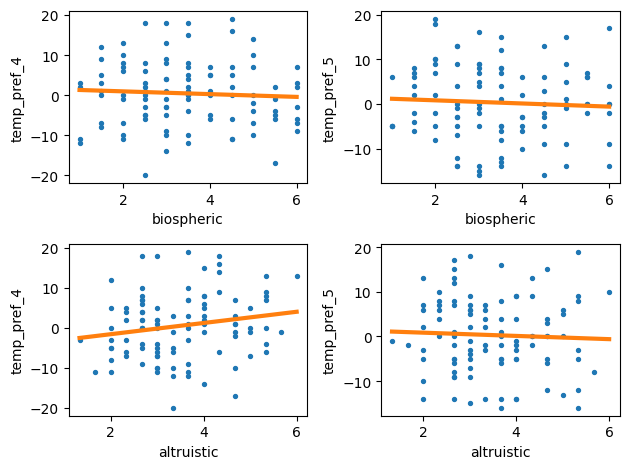

In [16]:
aggregations = ['biospheric', 'altruistic']
temp_prefs = [f'temp_pref_{i}' for i in (4,5)]

fig, axes = plt.subplots(nrows=len(aggregations), ncols=len(temp_prefs))
# results = []
for (i_x, aggregation), (i_y, temp_pref) in product(enumerate(aggregations), enumerate(temp_prefs)):
    reg = LinearRegression().fit(responses_t1[aggregation].values.reshape(-1,1), differences[temp_pref])
    # results.append((aggregation, temp_pref, reg.coef_, reg.intercept_))

    x_test = np.array([
        [responses_t1[aggregation].min()],
        [responses_t1[aggregation].max()],
    ])
    y_pred = reg.predict(x_test)

    axes[i_x, i_y].scatter(responses_t1[aggregation], differences[temp_pref], s=8)
    axes[i_x, i_y].plot(x_test, y_pred, color='C1', linewidth=3)
    axes[i_x, i_y].set_xlabel(aggregation)
    axes[i_x, i_y].set_ylabel(temp_pref)

plt.tight_layout()
fig.show()

 2.	Stronger egoistic and hedonic values (Ego_values, Hed_values) will be associated with larger differences in temperature settings between time one (temp_pref_4, temp_pref_5, temp_pref_6) and time two (temp_pref_4_t2, temp_pref_5_t2, temp_pref_6_t2).
Proposed analysis: Pearson’s correlation or linear regression.

3.	Stronger biospheric and altruistic values (Bio_values, Altr_values) will be associated with smaller differences in curtailment behaviours between time one (empty, clothes, night, away, shut, shw_time, shw_time, shw_time_num, shw_frw_num, bath_num) and time two (empty_t2, clothes_t2, night_t2, away_t2, shut_t2, shw_time_t2, shw_time_t2, shw_time_num_t2, shw_frw_num_t2, bath_num_t2).
Proposed analysis: Pearson’s correlation or linear regression.

4.	Stronger egoistic and hedonic values (Ego_values, Hed_values) will be associated with bigger differences in curtailment behaviours between time one (empty, clothes, night, away, shut, shw_time, shw_time_num, shw_frw_num, bath_num) and time two (empty_t2, clothes_t2, night_t2, away_t2, shut_t2, shw_time_t2, shw_time_t2, shw_time_num_t2, shw_frw_num_t2, bath_num_t2).
Proposed analysis: Pearson’s correlation or linear regression.